In [1]:
#Allows relative imports
import os
import sys
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import *
from src.train_eval_helpers import *
from src.plots import *
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
sns.set_style('darkgrid')

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

RANGE = range(12,17)
TRAINDIR = '../TrainingData/'

Using : cuda


In [2]:
#Getting models
models = load_models('../output/training_output/richie_minmax_redo_withnograd/', arch = 'richie', eval_=True)
deepcats = load_models('../output/training_output/benchmark/', arch='deepcat', eval_=True)

Models & weights loaded
Models & weights loaded


In [3]:
def parse_tsv(filepath):
    temp = pd.read_csv(filepath, sep='\t',header = 0, usecols=['CDR3','MHC class','Epitope','Epitope gene', 'Epitope species'])
    temp = temp.dropna()
    temp['len']= temp.apply(lambda x: len(x['CDR3']),axis=1)
    temp = temp.query('(CDR3.str.startswith("C") and CDR3.str.endswith("F"))')
    temp = temp.query('not CDR3.str.contains("\*")')
    temp = temp.query('`MHC class` != "MHCII"')
    temp = temp.query('len>=12 and len <=16')
    temp = temp.query('`Epitope gene`!="synthetic"')
    return temp.sort_values('Epitope gene')
def parse_csv(filepath):
    temp = pd.read_csv(filepath, header = 0, usecols=['epitope','cdr3_TRB'])
    temp = temp.dropna()
    temp['len']= temp.apply(lambda x: len(x['cdr3_TRB']),axis=1)
    temp = temp.query('(cdr3_TRB.str.startswith("C") and cdr3_TRB.str.endswith("F"))')
    temp = temp.query('not cdr3_TRB.str.contains("\*")')
    temp = temp.query('len>=12 and len <=16')
    return temp

In [4]:
a=parse_csv('../NewData/db_pos.csv')

In [5]:
a=parse_csv('../NewData/db_pos.csv')
epitope_map = {
    "ELAGIGILTV" : 1 #Melanoma MLANA
    ,"GILGFVFTL"  : 0 #Influenza A M gene
    ,"SLFNTVATLY" : 0 #HIV
    ,"RMFPNAPYL" : 1 #WT1
    ,"LLDFVRFMGV" : 1 #EBNA-B EBV but also linked to 
    ,"GLCTLVAML" : 1 #BMLF1 ebv
    ,"LLFGYPVYV" : 0 #HTLV-1 Tax
    ,"SLLMWITQV" : 1 #well known squamous cell NY-ESO
    ,"FLYALALLL" : 1 #EBV LMP2A, but linked to lymphoma
    ,"FLASKIGRLV" : 0 # PLA2G6 phospholipase
    ,"MLDLQPETT" : 1 #HPV E7
    ,"IMDQVPFSV" : 1 #PMEL melanosome....
    ,"YLLEMLWRL" : 1 #EBV lmp1 viral oncogene
    ,"KVLEYVIKV" : 1 #MAGE A1
    ,"RTLNAWVKV" : 0 #HIV gag1
    ,"KTWGQYWQV" : 1 #PMEL
    ,"YLNDHLEPWI" : 1 #BCL-2-l1
    ,"SLFNTVATL" : 0 #HIV Gag 1
    ,"CLLWSFQTSA" : 0 #tyr (ALBINISM)
    ,"ILKEPVHGV" : 0 #HIV1 POL
    ,"CLLGTYTQDV" : 0 #KANAMYCYN KANJ (ANTIBIO)
    ,"NLVPMVATV" :  0 #H CMV
    ,"KLQCVDLHV" : 0 # klk3
    ,"ELAGIGLTV" : 1 #MLANA
    ,"VLEETSVML" : 0 #CMV IE1
    ,"YVLDHLIVV" :  0 #HPV brlf1
    ,"FLGKIWPSHK" : 0 # HIV gag1
    ,"CLNEYHLFL" : 0 # human NDC1
    ,"AMFWSVPTV" : 0 #TKT phosphate glycolysis 
    ,"FLYNLLTRV" :  0 #SEC24A
    ,"KLMNIQQKL" : 1 #AKAP13
    ,"IILVAVPHV" : 0 #EXOC8
    ,"MLGEQLFPL" : 0 #PABPC1
    ,"YILEETSVM" : 0 # CMV IE1
    ,"CINGVCWTV" :  1 #NS3 Hep C??
    ,"KLSALGINAV" : 1 #NS3 Hep C??
    ,"LLWNGPMAV" :  1 #NS4B Hep C??
    ,"TLNAWVKVV" : 0 #HIV GAG1
    ,"KINAWIKVV" : 0 #HIV gag
    ,"SLYNTVATL" : 0 #HIV gag
    ,"CVNGSCFTV" : 0 #Influenza A
    ,"ARNLVPMVATVQGQN" : 0 #pp65
    ,"LSEFCRVLCCYVLEE" : 0 #CMV IE1
    ,"LLFGYAVYV" : 0 # HLTV tax
    ,"LLFGYPRYV" : 0 #HLTV tax
    ,"SLLMWITQC" : 1 #NY-ESO-1
    ,"LLFGKPVYV" : 0 #HLTV tax
    ,"LLFGPVYV" : 0 #HLTV tax
    ,"MLWGYLQYV" : 0 #HLTV tax
    ,"LGYGFVNYI" : 0 #TAX
    ,"AAGIGILTV" : 1 #MLANA
    ,"LLFGFPVYV" : 0 #tax
    ,"ALWGPDPAAA" : 0 #Insuline INS
    ,"ELAAIGILTV" : 1 #MLANA
    ,"ELAGIGALTV" : 1 #MLANA
    ,"ILAKFLHWL" : 1 #TERT
    ,"EAAGIGILTV" : 1 # MLANA
    ,"LLFGYPVAV" : 0 #Tax HTLV
    ,"ALGIGILTV" : 1 #MLANA
    ,"LLLGIGILV" : 0 #BST2
    ,"KLVALGINAV" : 1 #NS3 hepc
    ,"CLGGLLTMV" : 1 #LMP2A
    ,"NLSALGIFST" : 0#IGF2BP2
    ,"MLNIPSINV" :0#pp65
    ,"VAANIVLTV" : 0#SLC30A8
}

In [6]:
a['label'] = a['epitope'].apply(lambda x: epitope_map[x])

In [7]:
b = parse_tsv('../NewData/search.tsv')

In [ ]:
,"5T4" : 1 #oncofoetal
,"ABCB5" : 1 #melanoma but also healthy skin
,"ABCD3" : 0 #
,"AKAP13" : 1 #oncogene encoding
,"AKAP9" : 0
,"API5" : 1 #apoptosis inhibitor
,"ARHGAP35" : #RHO GTPase activating prot 35, sounds cancerous lol 
,"ARMT1" : 
,"ASTN1" : 
,"BCL2L1" : 1
,"BMLF1" : 1
,"BRAP" : 1
,"BRLF1" : 
,"BST2" : 
,"BZLF1" : 
,"CADPS2" : 
,"CD74" : 
,"CDK4" : 
,"CDKN2A" : 
,"COL18A1" : 
,"CRISPLD1" : 
,"DPY19L4" : 
,"E7" : 
,"EBNA1" : 
,"EBNA3A" : 
,"EBNA3B" : 
,"EBNA4" : 
,"EBNA6" : 
,"ELAVL4" : 
,"ERBB2" : 
,"EXOC8" : 
,"FANCI" : 
,"FBXO21" : 
,"FNDC3B" : 
,"GANAB" : 
,"GCN1L1" : 
,"GEMIN" : 
,"GINS1" : 
,"GNB5" : 
,"GNL3L" : 
,"Gag" : 0
,"H3F3B" : 
,"IE-1" : 
,"IE1" : 0
,"IE2" : 
,"IGF2BP2" : 
,"INS" : 0
,"KARS" : 0
,"KIAA0368" : 
,"KIAA1279" : 
,"KIAA1967" : 
,"KIF16B" : 
,"KLHL7" : 
,"KLK3" : 0
,"KRAS" : 1
,"KanJ" : 0
,"LMP1" : 1
,"LMP2A" : 
,"M" : 
,"MAGE-A1" : 1
,"MAGE-A3" : 1
,"MAGEA1" : 1
,"MAGEA3" : 1
,"MAGEA6" : 1
,"MART1" : 
,"MED13" : 
,"MLANA" : 1
,"MLL2" : 
,"MPV17" : 
,"NBAS" : 
,"NDC1" : 
,"NP" : 
,"NS3" : 1
,"NS4B" : 1
,"NS5B" : 1
,"NUP98" : 
,"NY-ESO" : 1
,"NY-ESO-1" : 1
,"Nef" : 0
,"PABPC1" : 0
,"PDE4A" : 
,"PDE7B" : 
,"PGM5" : 
,"PHKA1" : 
,"PHLPP1" : 
,"PLA2G6" : 0
,"PMEL" : 1
,"POGK" : 
,"PORCN" : 
,"Pol" : 
,"RECQL5" : 
,"RFC5" : 
,"RNF10" : 
,"RNF19B" : 
,"RNF213" : 
,"SEC24A" : 
,"SKIV2L" : 
,"SLC30A8" : 
,"SMARCD3" : 
,"SNX24" : 
,"SRPX" : 
,"SSX2" : 
,"Spike" : 
,"T-Ag" : 
,"TERT" : 1
,"TKT" : 0
,"TP53" : 1
,"TUBGCP2" : 
,"TXNDC11" : 
,"TYR" : 0
,"Tax" : 0
,"Tel1" : 
,"Tyrosinase" : 0
,"U2AF2" : 
,"UGGT2" : 
,"UL29/28" : 
,"UL40" : 
,"UL49" : 
,"Vif" : 
,"Vpr" : 
,"WDR87" : 
,"WT1" : 1
,"XPNPEP1" : 
,"ZDBF2" : 
,"ZFYVE27" : 
,"gp100" : 1
,"p53" : 1
,"pp50" : 0
,"pp65" : 0

In [8]:
cdr3_label_map = dict(zip(a['cdr3_TRB'].values, a['label'].values))
control = a.query('label==0')
tumor = a.query('label==1')

In [9]:
dc_feats, dc_labs = generate_features_labels(tumor['cdr3_TRB'].values,
                                            control['cdr3_TRB'].values,
                                           encoding = 'aaidx', scaling=None)
rich_feats, rich_labs = generate_features_labels(tumor['cdr3_TRB'].values,
                                            control['cdr3_TRB'].values, encoding='aa_atchley', scaling='minmax')


Getting data
Data device = cpu
Done loading, returning features and labels.
Getting data
Data device = cpu
Done loading, returning features and labels.


In [10]:
_, dc_accs, dc_aucs, dc_f1, dc_curves = test_eval(deepcats, dc_feats, dc_labs,range(12,17), nn.CrossEntropyLoss(), return_curve=True)
_, rich_accs, rich_aucs, rich_f1, rich_curves =  test_eval(models, rich_feats, rich_labs,range(12,17), nn.CrossEntropyLoss(), return_curve=True)
plot_roc_comparison(dc_curves, rich_curves, name='VDJdb data parsed by Giancarlo',save='vdjdb_giancarlo.jpg')#, keys=range(12,17), save=None)

In [20]:
z = control.sample(10)

In [22]:
z.len.unique()

array([14, 12, 13, 16, 15], dtype=int64)

In [23]:
a,b =generate_features_labels(tumor['cdr3_TRB'].values,
                          z['cdr3_TRB'].values,
                          encoding='aa_atchley', scaling='minmax')

Getting data
Data device = cpu
Done loading, returning features and labels.


In [29]:
preds = {}
probs = {}
for key in range(12,17):
    models[key].eval()
    _, pred, prob = models[key](a[key])
    preds[key] = pred
    probs[key] = prob[:,1]

In [33]:
len(probs[12][probs[12]<=0.5])

146

(<Figure size 4320x2880 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'ROC_AUC on test set for L = 12, total 3182 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 13, total 6412 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 14, total 8481 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>],
        [<AxesSubplot:title={'center':'ROC_AUC on test set for L = 15, total 7040 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 16, total 2846 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:>]], dtype=object))

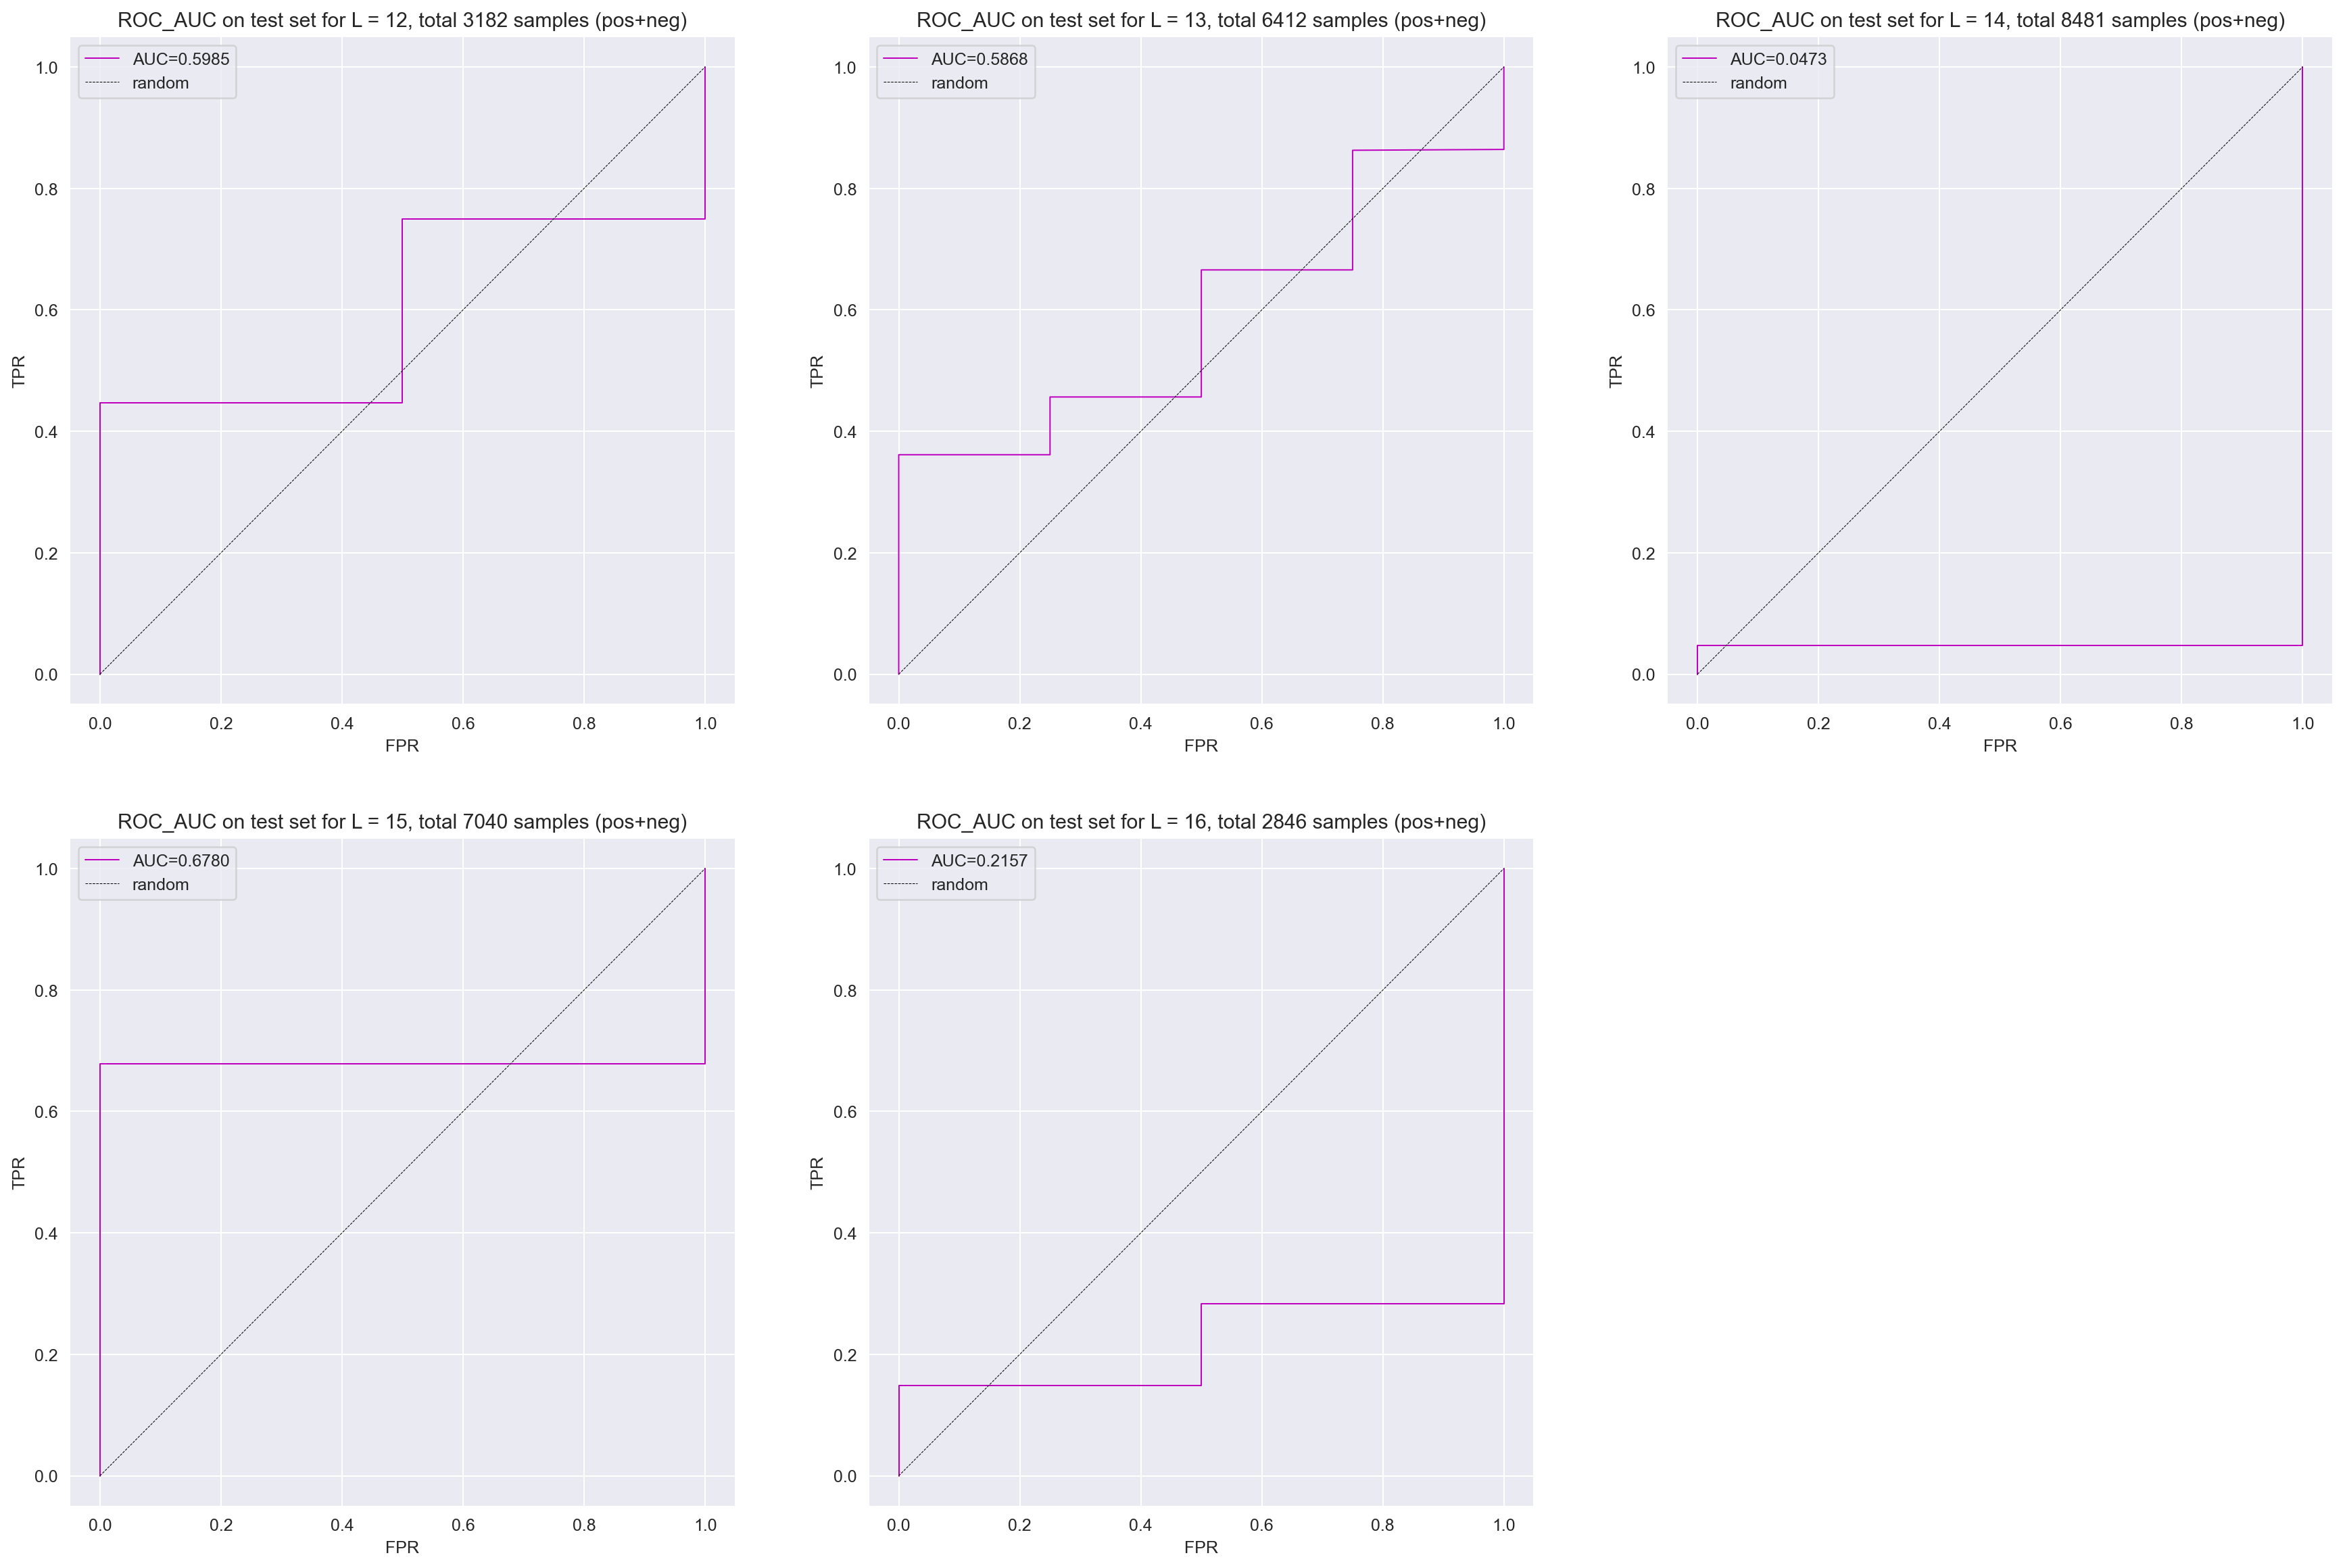

In [25]:
_, _,_,_, xd =  test_eval(models, a, b,range(12,17), nn.CrossEntropyLoss(), return_curve=True)
plot_roc_curve(xd, keys=range(12,17), save = None)